In [233]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [234]:
def MAPELoss(output, target):
    epsilon = 1e-20  # small value to prevent division by zero
    diff = torch.abs(target - output)
    return torch.mean(torch.abs(diff / (target + epsilon))) * 100

In [235]:
args = {'lr':0.01,
        'train epochs':750,
        'hidden layers':3,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'input features':30,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'correlation':0.2
        }

Data Prep

In [236]:
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [237]:
df = pd.read_excel('wide_range.xlsx')

In [238]:
X = df.iloc[:,11:]
y = df.iloc[:,:11]

Feature Selection

In [239]:
'''
for layer in layers:
    rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=args['input features'])

    inputs = X.copy()
    target = y[layer['col']]

    X_selected = rfe.fit_transform(inputs, target)
    selected_feature_indices = rfe.get_support(indices=True)
    
    features = []
    for i in selected_feature_indices:
        features.append(X.columns[i])

    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()}:\n {features}\n')
'''
'''
for layer in layers:
    if layer['layer'] < 9:
        layer['features'] = X.columns[:args['input features']]
    else: 
        layer['features'] = X.columns[-args['input features']:]
'''

for layer in layers:
    temp = X.copy()
    temp['layer'] = y[layer['col']]
    
    #features = temp.corr().abs()['layer'].sort_values(ascending=False).head(args['input features']+1).index[1:]

    corr_df = pd.DataFrame(temp.corr()['layer'].sort_values(ascending=False))
   
    features = []
    for index, row in corr_df.iterrows():
        if index == 'layer':
            continue
        
        if row['layer'] > args['correlation']:
            features.append(index)
        
    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()} ({len(features)}):\n {features}\n')


Features for Layer 1 (19):
 [3.95e-06, 4e-06, 3.9e-06, 4.05e-06, 3.85e-06, 3.8e-06, 4.1e-06, 3.75e-06, 4.15e-06, 4.2e-06, 4.25e-06, 4.3e-06, 4.55e-06, 4.6e-06, 4.5e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.65e-06]

Features for Layer 2 (19):
 [4.05e-06, 4e-06, 4.1e-06, 3.85e-06, 3.9e-06, 3.95e-06, 3.8e-06, 4.15e-06, 3.75e-06, 4.2e-06, 4.25e-06, 4.3e-06, 4.55e-06, 4.6e-06, 4.5e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.65e-06]

Features for Layer 3 (20):
 [4.2e-06, 4.15e-06, 4.25e-06, 3.75e-06, 4.1e-06, 3.8e-06, 4.3e-06, 4.05e-06, 3.85e-06, 3.9e-06, 4e-06, 4.55e-06, 3.95e-06, 4.6e-06, 4.5e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.65e-06, 4.7e-06]

Features for Layer 4 (20):
 [4.6e-06, 4.55e-06, 4.5e-06, 4.3e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.25e-06, 4.65e-06, 4.2e-06, 4.15e-06, 3.75e-06, 4.7e-06, 4.1e-06, 3.8e-06, 3.85e-06, 4.05e-06, 3.9e-06, 4e-06, 3.95e-06]

Features for Layer 5 (21):
 [4.6e-06, 4.5e-06, 4.55e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.3e-06, 4.65e-06, 4.25e-06, 4.2e-06, 4.7e-06, 4.15e-06, 3.7

In [240]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=X.shape)
X_noisy = X + noise

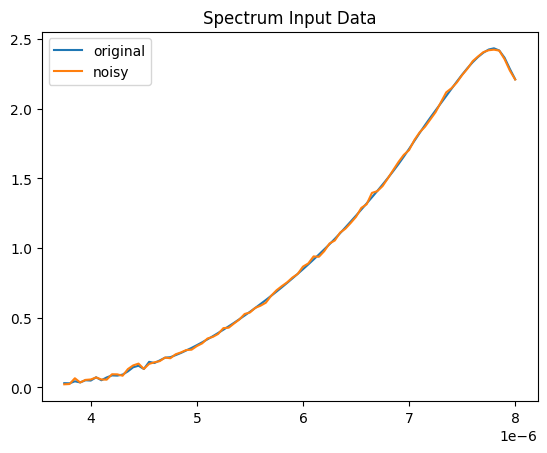

In [241]:
plt.title('Spectrum Input Data')
plt.plot(X.iloc[0], label='original')
plt.plot(X_noisy.iloc[0], label='noisy')
plt.legend()
plt.show()

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, train_size=args['train size'], random_state=101)

In [243]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

In [244]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        
        hidden_sizes = [input_size]
        step = int(input_size / (num_hidden+1))

        for i in range(num_hidden):
            hidden_size = input_size - (i+1) * step
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [245]:
criterion = args['train criterion']

In [246]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    model = FeedForward(input.size()[1], target.size()[1], args['hidden layers'])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])

    for epoch in range(args['train epochs']):
        outputs = model(input)

        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

[19, 15, 11, 7]
layer 1
epoch: 75, loss = 16.812475204467773
epoch: 150, loss = 9.944933891296387
epoch: 225, loss = 9.766100883483887
epoch: 300, loss = 9.688183784484863
epoch: 375, loss = 9.66401481628418
epoch: 450, loss = 9.655407905578613
epoch: 525, loss = 9.644354820251465
epoch: 600, loss = 9.631070137023926
epoch: 675, loss = 9.620294570922852
epoch: 750, loss = 9.610363960266113
best loss: 9.610193252563477 in epoch 748

[19, 15, 11, 7]
layer 2
epoch: 75, loss = 17.47903823852539
epoch: 150, loss = 10.467232704162598
epoch: 225, loss = 10.296891212463379
epoch: 300, loss = 10.217084884643555
epoch: 375, loss = 10.194241523742676
epoch: 450, loss = 10.18897533416748
epoch: 525, loss = 10.184282302856445
epoch: 600, loss = 10.18124771118164
epoch: 675, loss = 10.167924880981445
epoch: 750, loss = 10.15806770324707
best loss: 10.15806770324707 in epoch 750

[20, 15, 10, 5]
layer 3
epoch: 75, loss = 9.271214485168457
epoch: 150, loss = 6.984586238861084
epoch: 225, loss = 6.8698

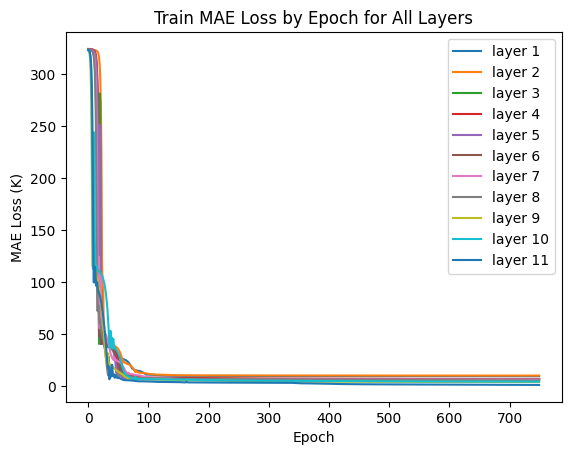

In [247]:
for layer in layers:
    plt.plot(layer['train losses'], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [248]:
test_losses = []
test_criterion = args['test criterion']

for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

layer 1 loss: 9.728949546813965
layer 2 loss: 10.372830390930176
layer 3 loss: 6.820527076721191
layer 4 loss: 7.263124465942383
layer 5 loss: 6.385304927825928
layer 6 loss: 6.648453235626221
layer 7 loss: 6.455400466918945
layer 8 loss: 5.548292636871338
layer 9 loss: 4.4602203369140625
layer 10 loss: 4.542784214019775
layer 11 loss: 1.2264851331710815


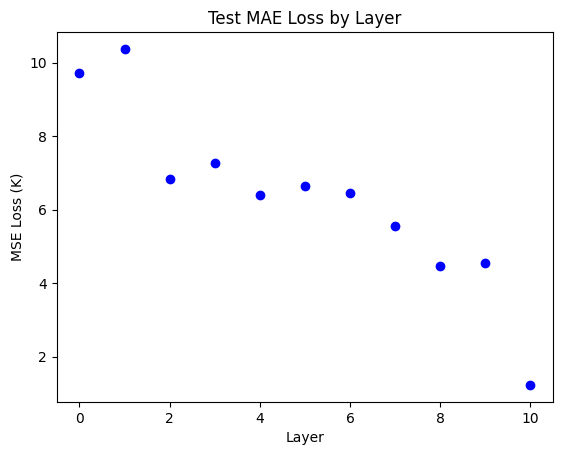

In [249]:
plt.plot(test_losses, 'bo')

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [250]:
def plot_comparison(pred, actual):
    plt.figure(figsize=(15, 5))
    plt.title("Temperature Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [251]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

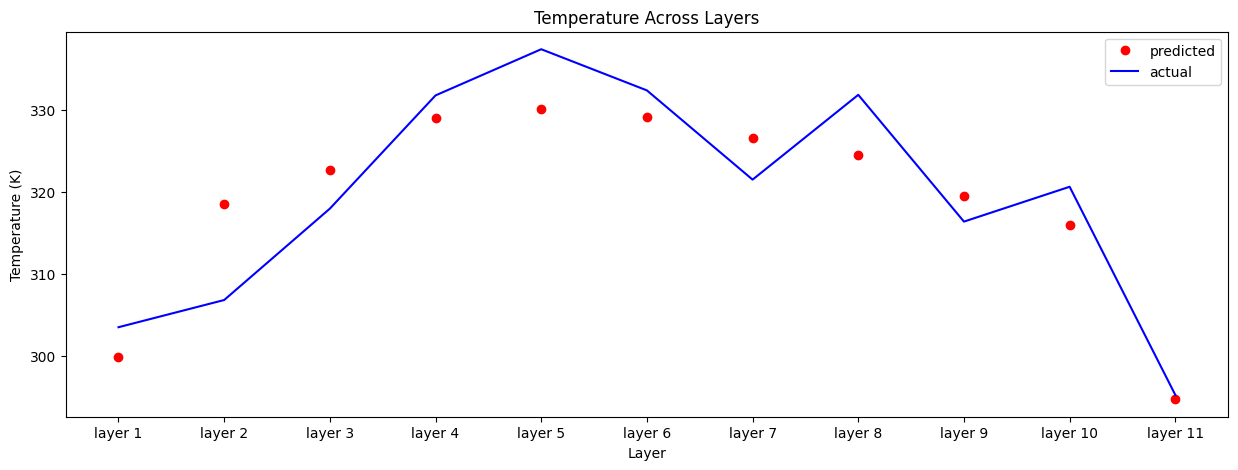

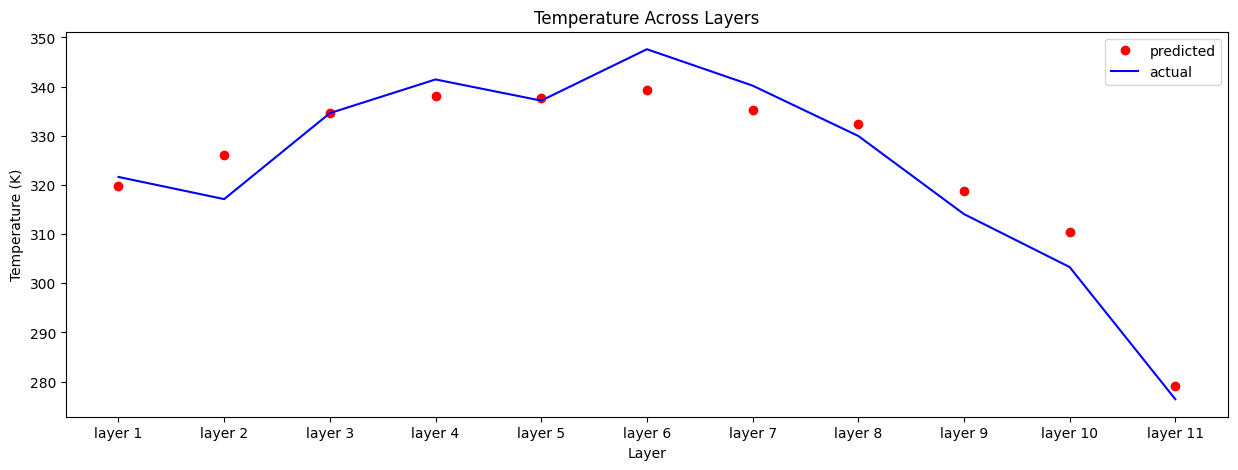

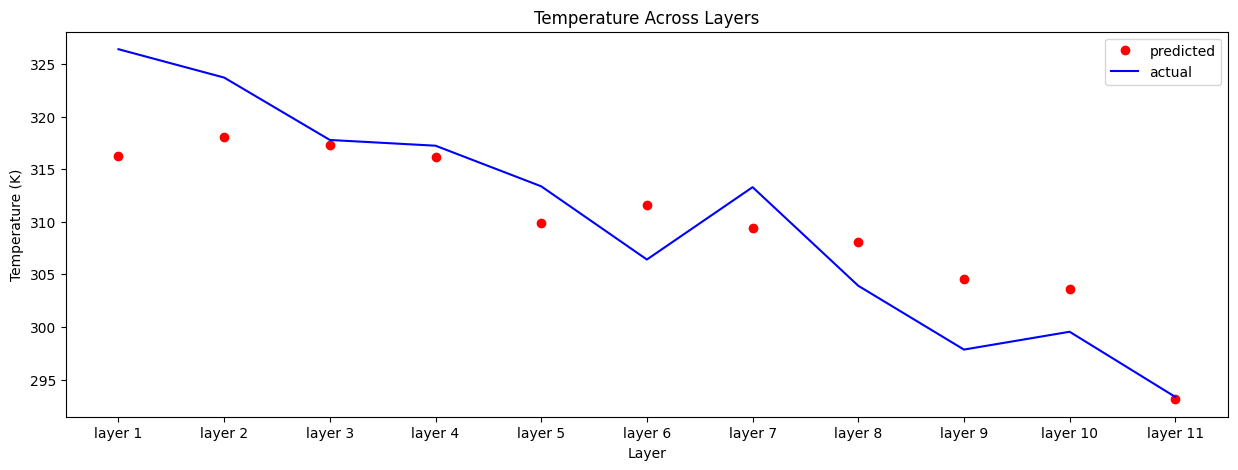

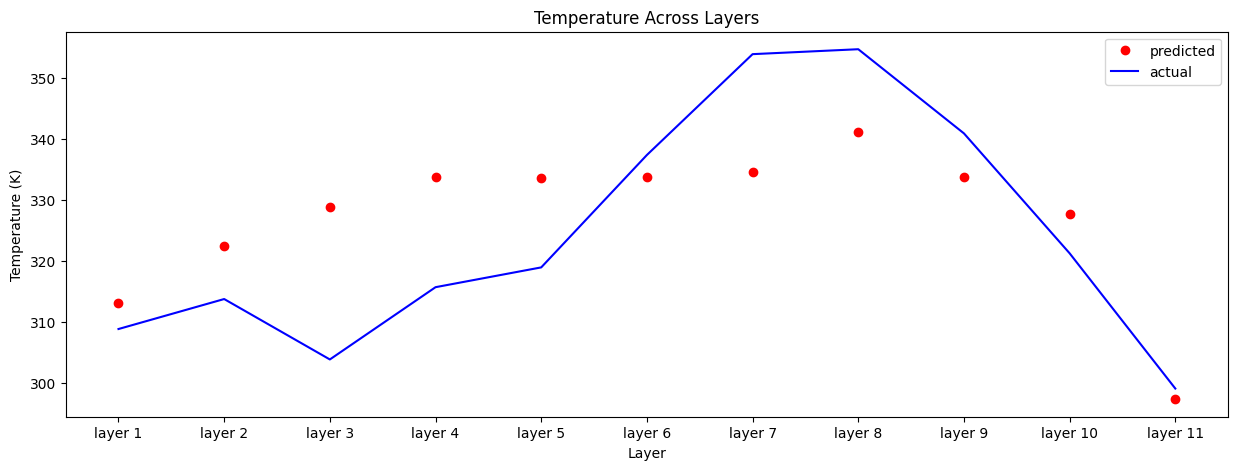

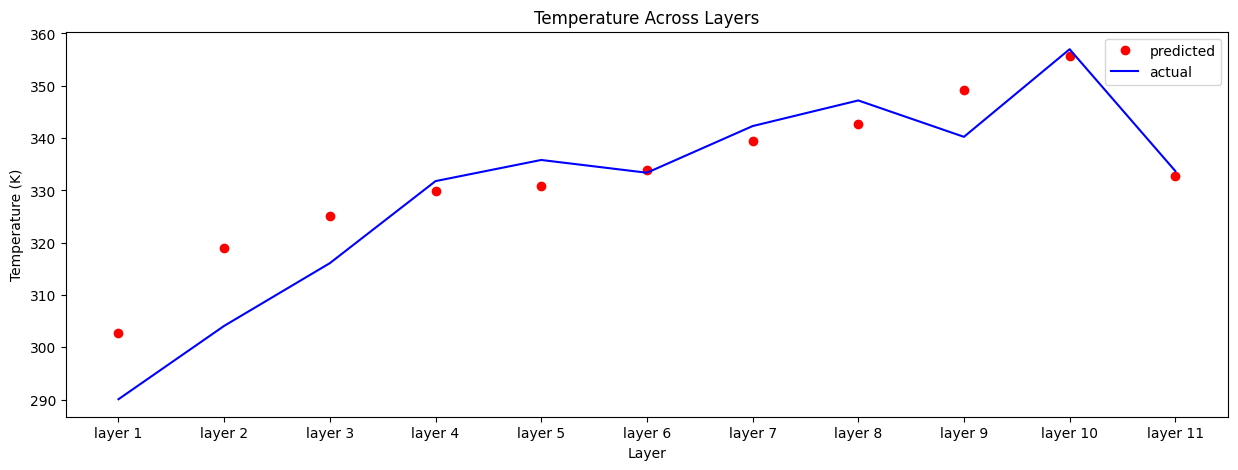

In [252]:


for i in range(0, len(y_test), int(len(y_test)/5)):
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual)